<a id="index"></a>
# A modular processing pipeline for spike sorting from axona raw data

In this notebook we will walk through a spike sorting processing pipeline with [SpikeInterface](https://github.com/SpikeInterface) for Axona raw (`.bin`) and axona unit (`.X`) data. There is another notebook for working with Intan data.

We will show how to

1. [Install `hussaini_lab_to_nwb`](#install_dependencies)
2. [load data with spikeextractors](#load_data)
3. [Preprocess the signals](#preprocess)
4. [Cache data](#cache)
5. [Spike sort](#spike_sorting)   
   * [Klusta](#klusta)
   * [mountainsort4](#mountainsort4)
   * [Ironclust](#ironclust)
   * [spyking circus](#spykingcircus)
   * [tridesclous](#tridesclous)
   
   
6. [Postprocess the signals](#postprocessing)
7. [Curate the spike sorting output](#spike_curation) using 
        1) quality metrics (automatic), 
        2) [Phy](https://github.com/cortex-lab/phy) (manual), and 
        3) consensus-based curation
8. [Export results to NWB](#export_nwb)
9. [Export results to TINT](#export_tint)


<a id='install_dependencies'></a>
# Install `hussaini_lab_to_nwb`
[back to index](#index)

You can install the package and its dependencies with `pip install hussaini_lab_to_nwb`. The dependencies are listed in `requirements.txt`. We recommend installing it in a clean virtual environment (e.g. with `conda` or `venv`). 

Note that some spike sorters require matlab or additional dependencies, which need to be installed separately. For an overview of possible spike sorters and their dependencies see https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html.

Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# General data handling and visualization
import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# SpikeInterface family
import spikeextractors as se
import spikewidgets as sw
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc

print(sys.version, sys.platform, sys.executable)

3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0] linux /home/sbuergers/spikeinterface/hussaini_test_pipeline2/venv/bin/python


In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 6)
plt.rcParams.update({'font.size':14})

/home/sbuergers/spikeinterface/hussaini_test_pipeline2/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<a id='load_data'></a>
# 2. Load data
[back to index](#index)

Set path and base filename (or `.set` filename) and create an `AxonaRecordingExtractor` (using `.bin` file) or `AxonaUnitRecordingExtractor` (using `.X` files) instance. It is assumed that the files are in the same directory.

In [4]:
use_raw_data = True  # False for reading `.X` data, True for reading `.bin` data

In [5]:
if use_raw_data:
    dir_name = r'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'
    base_filename = '20201004_Raw'
else:
    dir_name = r'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin'
    base_filename = 'axona_sample'

filename = os.path.join(dir_name, base_filename + '.set')
print(filename)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw.set


When reading `.X` data, `AxonaUnitRecordingExtractor` fills in the missing data between waveforms with Gaussian noise, which is required for spike sorting later on. The noise standard deviation can be set with the `noise_std` parameter.

In [6]:
if use_raw_data:
    recording = se.AxonaRecordingExtractor(filename=filename)
else:
    recording = se.AxonaUnitRecordingExtractor(filename=filename, noise_std=15)

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). Below we illustrate a few useful methods that describe this particular recording.

In [7]:
print('Type of recorindextractor:', type(recording))
print('Channel ids: {}'.format(recording.get_channel_ids()))
print('Num. channels = {}'.format(len(recording.get_channel_ids())))
print('Sampling frequency = {} Hz'.format(recording.get_sampling_frequency()))
print('Num. samples = {}'.format(recording.get_num_frames()))
print('Stdev. on third channel = {}'.format(np.std(recording.get_traces(
    start_frame=0, end_frame=48000, channel_ids=2))))

Type of recorindextractor: <class 'spikeextractors.extractors.neoextractors.axonaextractor.AxonaRecordingExtractor'>
Channel ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Num. channels = 16
Sampling frequency = 48000.0 Hz
Num. samples = 28800300
Stdev. on third channel = 28.09267807006836


/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, 

The `spikewidgets` module includes several convenient plotting functions that can be used to explore the data, for instance by visualizing snippets of data in the time domain:

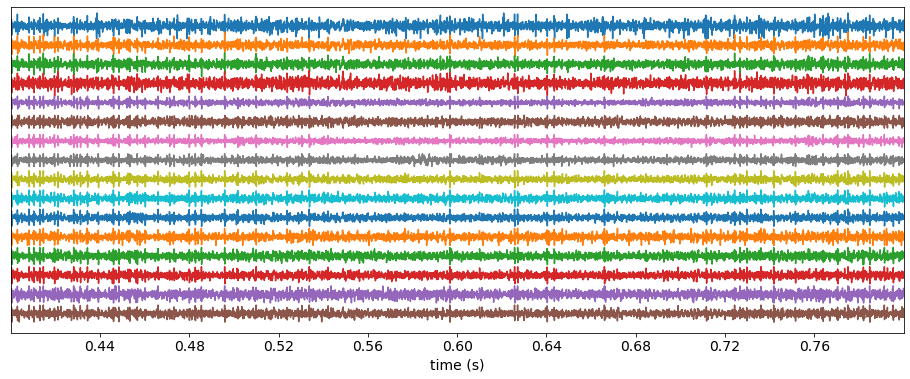

In [8]:
w_ts = sw.plot_timeseries(recording, trange=[0.4, 0.8])

Or in the frequency domain:

/home/sbuergers/spikeinterface/hussaini_test_pipeline2/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853

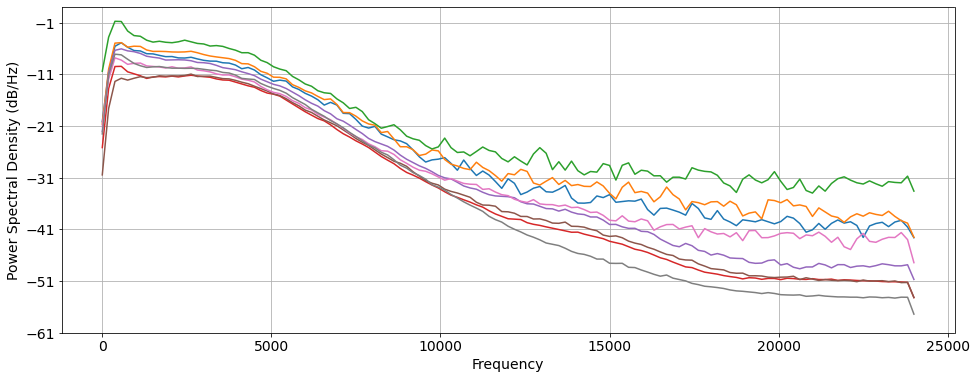

In [9]:
w_sp = sw.plot_spectrum(recording, trange=[0, 5], channels=[1, 2, 3, 4, 5, 6, 7, 8])

It often makes sense to group electrodes together, for instance if they belong to the same tetrode. When reading Axona data channels are automatically grouped by tetrode membership by reading the information form the `.set` file. If desired, or if using a different recording system where groups are not automatically assigned, the `set_channel_groups()` method can be used. Correspondingly, we can view the `group` property using the `get_channel_groups` method. 

An alternative way to obtain channel groups is by loading a so called `.prb` file containing channel grouping and physical channel locations. We do not need it here, but it is well explained in this [spikeinterface tutorial](https://github.com/SpikeInterface/spiketutorials/blob/master/NWB_Developer_Breakout_Session_Sep2020/SpikeInterface_Tutorial.ipynb).

In [10]:
print(f'Channel groups:\n{recording.get_channel_groups()}')

Channel groups:
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


/home/sbuergers/spikeinterface/hussaini_test_pipeline2/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Some spike sorters (e.g. ironclust) require channel locations. So we will create a fake geometry keeping electrodes on single tetrodes close together. One could use a `.prb` file to accomplish this, but we will simply assign locations with the `set_channel_locations()` method. If the actual geometry is known, you can of course use that instead. 

In [11]:
recording.set_channel_locations(locations=[[0,0],[0,1],[0,2],[0,3],
                                           [0,10],[0,11],[0,12],[0,13],
                                           [0,20],[0,21],[0,22],[0,23],
                                           [0,30],[0,31],[0,32],[0,33]],
                                channel_ids=recording.get_channel_ids())

We now have the additional channel property `location`.

In [12]:
print('Channel ids:', recording.get_channel_ids())
print('Loaded properties', recording.get_shared_channel_property_names())

# 'group' and 'location' can be returned as lists:
print('Channel groups:', recording.get_channel_groups())
print('Channel locations:\n', recording.get_channel_locations())

Channel ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Loaded properties ['gain', 'group', 'location', 'name', 'offset']
Channel groups: [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
Channel locations:
 [[ 0.  0.]
 [ 0.  1.]
 [ 0.  2.]
 [ 0.  3.]
 [ 0. 10.]
 [ 0. 11.]
 [ 0. 12.]
 [ 0. 13.]
 [ 0. 20.]
 [ 0. 21.]
 [ 0. 22.]
 [ 0. 23.]
 [ 0. 30.]
 [ 0. 31.]
 [ 0. 32.]
 [ 0. 33.]]


And we can visualize the electrode locations with spikewidgets:

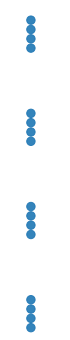

In [13]:
fh = plt.figure(figsize=(1,6))
w_elec = sw.plot_electrode_geometry(recording, figure=fh)

### Properties (and features)

For now we have seen that the `RecordingExtractor` can have `group` and `location` *properies*. These are very special properties that can be very important for spike sorting. But anything related to a channel can be saved as a property.

Similarly, for `SortingExtractor` objects, anything related to a unit can be stored as a property. In addition, for `SortingExtractor` objects we can also store anything related to spikes as *features* (e.g. waveforms, as we'll see later).

We can check which properties are in the extractor as follows:

In [14]:
print('Shared channel property names')
print(recording.get_shared_channel_property_names())

Shared channel property names
['gain', 'group', 'location', 'name', 'offset']


<a id='preprocess'></a>
# 3. Preprocessing
[back to index](#index)

Next, we will perform a few preprocessing steps using `spiketoolkit`.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, and more (see [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, we will filter the recordings, apply common median reference (CMR) and remove noisy channels (for illustration purposes). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

### Bandpass filter

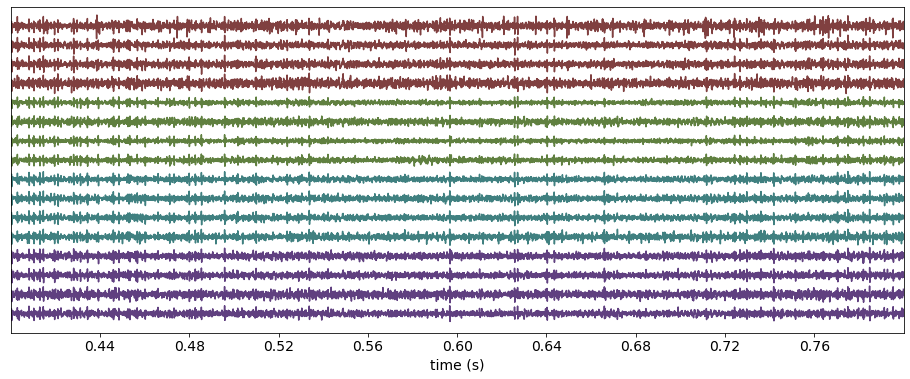

In [15]:
r_filt = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(r_filt, trange=[0.4, 0.8], color_groups=True)

### Common median reference (CMR)

It is often desirable to use a common median reference to remove noise common to all channels.

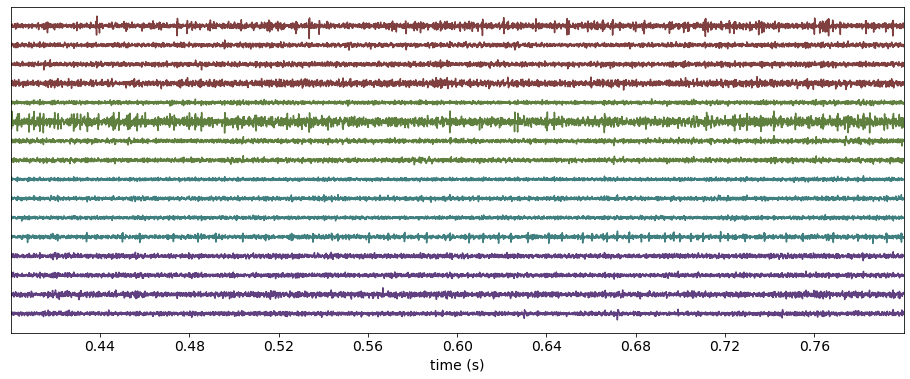

In [16]:
r_cmr = st.preprocessing.common_reference(r_filt, reference='median')
w = sw.plot_timeseries(r_cmr, trange=[0.4, 0.8], color_groups=True)

### Remove bad channels

Some channels look more noisy than others. This could negatively influence the spike sorters, so let's remove some of the noisier channels (of course for actual analyses it might be better to use a more objective approach). We can do so as follows (alternatively we could create a `SubRecordingExtractor` and specify the channel IDs to keep):

In [17]:
channel_ids = np.array(r_cmr.get_channel_ids())
r_good_channels = st.preprocessing.remove_bad_channels(r_cmr, bad_channel_ids=channel_ids[[0, 3, 5]])
print(f'Channel ids after removing bad channel: {r_good_channels.get_channel_ids()}')
print(f'Channel groups after removing bad channel: {r_good_channels.get_channel_groups()}')

Channel ids after removing bad channel: [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channel groups after removing bad channel: [0 0 1 1 1 2 2 2 2 3 3 3 3]


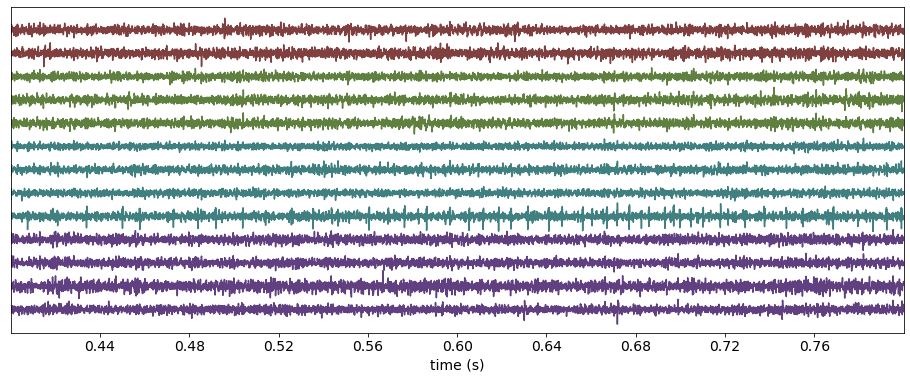

In [18]:
w = sw.plot_timeseries(r_good_channels, trange=[0.4, 0.8], color_groups=True)

We can also select subsets of data in the time domain with `SubRecordingExtractor`. For illustrative purposes and to speed up computation time of the spike sorters, we will select a 2 min sub-window. 


In [19]:
fs = r_cmr.get_sampling_frequency()
r_sub = se.SubRecordingExtractor(r_good_channels, start_frame=0*fs, end_frame=120*fs)

<a id='cache'></a>
# 4. Cache data
[back to index](#index)

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to perform those operations (eg. filters, CMR, etc.) once and **cache** the processed data to a file. This is particularly important if we are going to extract waveforms, templates, pca scores, or in general *post-process* the results.

Note that if the parameter `save_path` is not specified, the cache file will be saved in a temporary folder that will be deleted when the Python session is closed (or the object destroyed). One can get around this by moving the temporary file with `recording_cache.move_to()`, or simply specifying the `save_path` paramter when creating the cache. You can view the directory of the temporary folder with `recording_cache.get_tmp_folder()`.

In [20]:
perma_cache_filename = os.path.join(dir_name, 'cached_data_preproc.dat') 
r_cache = se.CacheRecordingExtractor(r_sub, save_path = perma_cache_filename)
print('Temporary folder:\n{}'.format(r_cache.get_tmp_folder()))

Temporary folder:
/tmp/tmpe4pqghcw


Under the hood, this convenient function is retrieving all the traces (in chunks, to save up some memory), applying the preprocessing steps, and dumping them to a binary temporary file:

In [21]:
print(f'Filename: {r_cache.filename}')

Filename: /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/cached_data_preproc.dat


The cached recording has all the previously loaded information:

In [22]:
print(f'Cached channels: {r_cache.get_channel_ids()}')
print(f'Cached channels ids: {r_cache.get_channel_ids()}')
print(f'Channel groups after caching: {r_cache.get_channel_groups()}')
print('Duration of recording in seconds: {}'.format(r_cache.get_num_frames() / r_cache.get_sampling_frequency()))

Cached channels: [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Cached channels ids: [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channel groups after caching: [0 0 1 1 1 2 2 2 2 3 3 3 3]
Duration of recording in seconds: 120.0


If we now closed the Python session, we would have a nice `.dat` file, but no information on how to open it! 
In order to save the state of an extractor, we can use the **dumping** mechanism.
Each extractor can be converted to a dictionary, which holds the path to the data file and all relevant information:

In [23]:
r_cache.dump_to_dict()

{'class': 'spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor',
 'module': 'spikeextractors',
 'kwargs': {'file_path': '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/cached_data_preproc.dat',
  'sampling_frequency': 48000.0,
  'numchan': 13,
  'dtype': 'float32',
  'recording_channels': [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  'time_axis': 0,
  'geom': None,
  'file_offset': 0,
  'gain': None,
  'is_filtered': True},
 'key_properties': {'group': array([0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]),
  'location': array([[ 0.,  1., nan],
         [ 0.,  2., nan],
         [ 0., 10., nan],
         [ 0., 12., nan],
         [ 0., 13., nan],
         [ 0., 20., nan],
         [ 0., 21., nan],
         [ 0., 22., nan],
         [ 0., 23., nan],
         [ 0., 30., nan],
         [ 0., 31., nan],
         [ 0., 32., nan],
         [ 0., 33., nan]]),
  'gain': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

We can now dump our extractor object, so it can be loaded in a future session. We can dump either to `.json` or to `.pkl`. Dumping to pickle also allows us to store properties (other than group and locations) and features (for `SortingExtractor` objects).

In [24]:
r_cache.dump_to_pickle(os.path.join(dir_name, 'cached_data_preproc.pkl'))

In another session, we can pick up from where we left by loading the extractor from the pickle file:

In [11]:
r_cache = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_data_preproc.pkl'))

In [12]:
print(f'Cached channels ids: {r_cache.get_channel_ids()}')
print(f'Channel groups after caching: {r_cache.get_channel_groups()}')
print('Duration of recording in seconds: {}'.format(r_cache.get_num_frames() / r_cache.get_sampling_frequency()))

Cached channels ids: [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channel groups after caching: [0 0 1 1 1 2 2 2 2 3 3 3 3]
Duration of recording in seconds: 120.0


__Note__: the same caching/dumping mechanisms are available also for all `SortingExtractor` objects.

<a id='spike_sorting'></a>
# 5. Spike sorting
[back to index](#index)

We will now run spike sorting on the above recording (`r_cache`). We will show code for `klusta`, `ironclust`, `mountainsort4`, `spykingcircus` and `trideclous` for this demonstration, but there are many other spike sorting algorithms available, all of which can be accessed with the same `spikeinterface` API.

First, we need to install the spike sorters we want. There is a complete overview of spike sorters supported by spikeinterface [here](https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html), including installation instructions. Note that not all spikesorters work on every setup. Some require Matlab. Some require CUDA. 

We can list all installed spike sorting algorithms with the following convenience function.

In [13]:
ss.installed_sorters()

['mountainsort4']

<a id='klusta'></a>
### Klusta
[back to index](#index)

Install `Klusta` with pip.

In [45]:
!pip install Cython h5py tqdm
!pip install click klusta klustakwik2

You should consider upgrading via the '/home/sbuergers/spikeinterface/spikeinterface_new_api/venv/bin/python3 -m pip install --upgrade pip' command.
  Using cached click-8.0.1-py3-none-any.whl (97 kB)
  Using cached klusta-3.0.16-py2.py3-none-any.whl (87 kB)
  Using cached klustakwik2-0.2.6.zip (712 kB)
Using legacy 'setup.py install' for klustakwik2, since package 'wheel' is not installed.
    Running setup.py install for klustakwik2 ... error
    ERROR: Command errored out with exit status 1:
     command: /home/sbuergers/spikeinterface/spikeinterface_new_api/venv/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-777yvb7u/klustakwik2_ae8154c15f8b43429bdf572329473106/setup.py'"'"'; __file__='"'"'/tmp/pip-install-777yvb7u/klustakwik2_ae8154c15f8b43429bdf572329473106/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read(

          |             ^~~~~~~~
          |             curexc_type
    klustakwik2/numerics/cylib/compute_cluster_masks_cy.c:20269:13: error: ‘PyThreadState’ {aka ‘struct _ts’} has no member named ‘exc_value’; did you mean ‘curexc_value’?
    20269 |     tstate->exc_value = local_value;
          |             ^~~~~~~~~
          |             curexc_value
    klustakwik2/numerics/cylib/compute_cluster_masks_cy.c:20270:13: error: ‘PyThreadState’ {aka ‘struct _ts’} has no member named ‘exc_traceback’; did you mean ‘curexc_traceback’?
    20270 |     tstate->exc_traceback = local_tb;
          |             ^~~~~~~~~~~~~
          |             curexc_traceback
    klustakwik2/numerics/cylib/compute_cluster_masks_cy.c: In function ‘__Pyx__ExceptionSwap’:
    klustakwik2/numerics/cylib/compute_cluster_masks_cy.c:21817:24: error: ‘PyThreadState’ {aka ‘struct _ts’} has no member named ‘exc_type’; did you mean ‘curexc_type’?
    21817 |     tmp_type = tstate->exc_type;
          |         

Finally, we should downgrade h5py to version 2.10.0 to be as compatible as possible with spikesorters

In [47]:
!pip install h5py==2.10.0

You should consider upgrading via the '/home/sbuergers/spikeinterface/spikeinterface_new_api/venv/bin/python3 -m pip install --upgrade pip' command.


We can retrieve the parameters associated with any sorter with the `get_default_params()` function from the `spikesorters` module, as well as corresponding parameter descriptions using `get_params_description()`.

In [33]:
ss.get_default_params('klusta')

{'adjacency_radius': None,
 'threshold_strong_std_factor': 5,
 'threshold_weak_std_factor': 2,
 'detect_sign': -1,
 'extract_s_before': 16,
 'extract_s_after': 32,
 'n_features_per_channel': 3,
 'pca_n_waveforms_max': 10000,
 'num_starting_clusters': 50,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [34]:
ss.get_params_description('klusta')

{'adjacency_radius': 'Radius in um to build channel neighborhood ',
 'threshold_strong_std_factor': 'Strong threshold for spike detection',
 'threshold_weak_std_factor': 'Weak threshold for spike detection',
 'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'extract_s_before': 'Number of samples to cut out before the peak',
 'extract_s_after': 'Number of samples to cut out after the peak',
 'n_features_per_channel': 'Number of PCA features per channel',
 'pca_n_waveforms_max': 'Maximum number of waveforms for PCA',
 'num_starting_clusters': 'Number of initial clusters',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)'}

In [50]:
ss.run_sorter?

In [51]:
ss.run_klusta?

Since we have tetrodes and we know that they are physically apart, we would like to sort them separately as follows, assigning the `group` property to the `grouping_property` parameter:

In [10]:
sorting_KL = ss.run_klusta(
    r_cache,
    adjacency_radius=5,
    output_folder=os.path.join(dir_name, 'klusta_by_group'),
    grouping_property='group',
    parallel=True
)
print(f'Klusta found {len(sorting_KL.get_unit_ids())} units')

SpikeSortingError: Spike sorting failed: klusta returned a non-zero exit code. You can inspect the runtime trace in the klusta.log of the output folder.'

Below you can see that when the `grouping_property` is used a `MultiSortingExtractor` object is returned, containing several `SortingExtractor` objects, which were created separately for each group. 

In [28]:
print(type(sorting_KL))
print(type(sorting_KL.sortings[0]))

<class 'spikeextractors.multisortingextractor.MultiSortingExtractor'>
<class 'spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor'>


In [29]:
print(f'Klusta unit ids (with groups): {sorting_KL.get_unit_ids()}')

Klusta unit ids (with groups): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [30]:
print(f'Spike train of a unit: {sorting_KL.get_unit_spike_train(1)}')

Spike train of a unit: [  41045   41055   41065   55619   55630   55636   55639   55660   70549
   70557   70706   70854   70858   71001   71104   71108   71114   71128
   71140   71145   71151   71177   71182   71186   71191   71207   71251
   71270   71287   71304   71344   71355   71381   71395   71473   71483
   71487   71503   71506   71511   71518   71532   71536   71570   71575
   71594   71598   71605   71622   71627   71631   71658   71665   71671
   71693   71696   71701   71706   71711   71733   71738   71744   71752
   71764   71775   71783   71798   71807   71817   71825   71832   71837
   71841   71849   71860   71866   71876   71881   71888   71908   71913
   71917   71922   71940   71946   71949   71955   71970   71981   71985
   71991   71996   72000   72033   72076   72146   73782   73803   73808
   73821   73826   73830   73841   73846   73859   73865   73876   73893
   73897   73903   73955   73958   73962   74072   74076   74080   74100
   74108   74115   74119   7

We can also visually inspect the data using raster plots.

In [27]:
w_rs = sw.plot_rasters(sorting_KL, trange=[0.4, 0.8])

NameError: name 'sorting_KL' is not defined

We can plot the temporal data for comparison, though it can be quite difficult to visually make out spiking events in noisy data. We will see more rigorous ways for assessing spike sorting outputs later on.

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

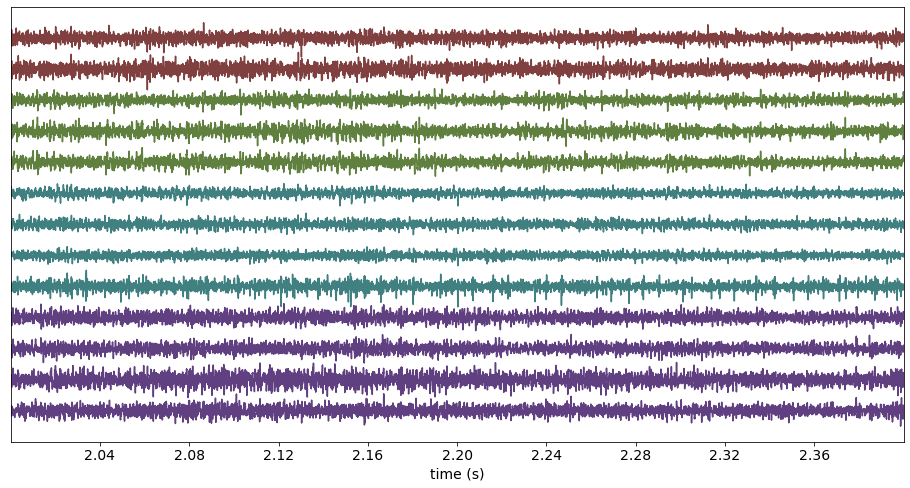

In [36]:
w = sw.plot_timeseries(r_cache, trange=[0.4, 0.8], color_groups=True)

### Loading spike sorting output from a spike sorting folder

If a spike sorter has been run, you can reload the output as a `SortingExtractor` using the corresponding `spikeextractors` class. Note that if sorting by group/property, single groups must be loaded separately:

In [25]:
sorting_KL_grp = []
for i in range(0, 3):
    sorting_KL_grp.append(se.KlustaSortingExtractor(os.path.join(dir_name, 'klusta_by_group', str(i))))

In [26]:
sorting_KL_grp
sorting_KL = se.MultiSortingExtractor(sorting_KL_grp)

In [27]:
sorting_KL

In [28]:
print(f'Klusta unit ids group 0: {sorting_KL_grp[0].get_unit_ids()}')

Klusta unit ids group 0: [0, 2, 3, 4]


### Saving and loading spike sorting output

It is also possible to save spike sorting output in a format of a different spike sorter using the `write_sorting()` method of the sorting extractor of interest. For instance, below we are saving the output from `klusta` in `mountainsort` format. 

In [41]:
sort_cache = se.CacheSortingExtractor(sorting_KL, save_path=os.path.join(dir_name, 'cached_sorting_KL.npz'))

sort_cache.dump_to_pickle(os.path.join(dir_name, 'cached_sorting_KL.pkl'))

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

Re-read data from file.

In [29]:
sorting_KL = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_sorting_KL.pkl'))

print('Unit ids = {}'.format(sorting_KL.get_unit_ids()))
spike_train = sorting_KL.get_unit_spike_train(unit_id=1)
print('Num. events for unit 1 = {}'.format(len(spike_train)))
spike_train1 = sorting_KL.get_unit_spike_train(unit_id=1, start_frame=0, end_frame=30000)
print('Num. events for first second of unit 1 = {}'.format(len(spike_train1)))

Unit ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Num. events for unit 1 = 385
Num. events for first second of unit 1 = 0


<a id='mountainsort4'></a>
### Mountainsort4
[back to index](#index)

Let's see if mountainsort is indeed installed.

In [17]:
ss.installed_sorters()

['mountainsort4']

In [15]:
ss.get_default_params('mountainsort4')

{'detect_sign': -1,
 'adjacency_radius': -1,
 'freq_min': 300,
 'freq_max': 6000,
 'filter': True,
 'whiten': True,
 'curation': False,
 'num_workers': None,
 'clip_size': 50,
 'detect_threshold': 3,
 'detect_interval': 10,
 'noise_overlap_threshold': 0.15}

In [16]:
ss.get_params_description('mountainsort4')

{'detect_sign': 'Use -1 (negative) or 1 (positive) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Radius in um to build channel neighborhood (Use -1 to include all channels in every neighborhood)',
 'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'filter': 'Enable or disable filter',
 'whiten': 'Enable or disable whitening',
 'curation': 'Enable or disable curation',
 'num_workers': 'Number of workers (if None, half of the cpu number is used)',
 'clip_size': 'Number of samples per waveform',
 'detect_threshold': 'Threshold for spike detection',
 'detect_interval': 'Minimum number of timepoints between events detected on the same channel',
 'noise_overlap_threshold': 'Noise overlap threshold for automatic curation'}

In [ ]:
sorting_MS4 = ss.run_mountainsort4(
    r_cache,
    os.path.join(dir_name, 'mountainsort4_group'),
    grouping_property='group',
    adjacency_radius=5,
    parallel=False,  # on my local machine mountainsort fails when parallel=True, that is not generally the case
    verbose=True,
    filter=False
)
print(f'Mountainsort4 found {len(sorting_MS4.get_unit_ids())} units')

/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, 

Using 4 workers.
Using tmpdir: /tmp/tmpmp5g4dkk
Num. workers = 4
Preparing /tmp/tmpmp5g4dkk/timeseries.hdf5...
Preparing neighborhood sorters (M=2, N=5760000)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmpmp5g4dkk
Using 4 workers.
Using tmpdir: /tmp/tmp2ebhqr37
Num. workers = 4
Preparing /tmp/tmp2ebhqr37/timeseries.hdf5...
Preparing neighborhood sorters (M=3, N=5760000)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmp2ebhqr37
Using 4 workers.
Using tmpdir: /tmp/tmp81z1o46a
Num. workers = 4
Preparing /tmp/tmp81z1o46a/timeseries.hdf5...
Preparing neighborhood sorters (M=4, N=5760000)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmp81z1o46a
Using 4 workers.
Using tmpdir: /tmp/tmpp1qn3acv
Num. workers = 4
Preparing /tmp/tmpp1qn3acv/timeseries.hdf5...
Preparing neighborhood sorters (M=4, N=5760000)...


In [9]:
print(f'Spike train of a unit: {sorting_MS4.get_unit_spike_train(1)}')

Spike train of a unit: [    624    1084    1581 ... 5756678 5758526 5759778]


Write spike sorting output to memory.

In [20]:
unit_ids = sorting_MS4.get_unit_ids()

sort_cache.copy_unit_properties(sorting_MS4, unit_ids=unit_ids)

print(sort_cache.get_unit_property_names(unit_id=0))

['group']


In [13]:
sorting_MS4._properties

{}

In [15]:
sorting_MS4_phy_curated._properties

{0: {'group': 0, 'quality': 'unsorted'},
 1: {'group': 0, 'quality': 'unsorted'},
 2: {'group': 1, 'quality': 'unsorted'},
 3: {'group': 1, 'quality': 'unsorted'},
 4: {'group': 1, 'quality': 'unsorted'},
 5: {'group': 1, 'quality': 'unsorted'},
 6: {'group': 1, 'quality': 'unsorted'},
 7: {'group': 1, 'quality': 'unsorted'},
 8: {'group': 1, 'quality': 'unsorted'},
 9: {'group': 2, 'quality': 'unsorted'},
 10: {'group': 2, 'quality': 'unsorted'},
 11: {'group': 2, 'quality': 'unsorted'},
 12: {'group': 2, 'quality': 'unsorted'},
 13: {'group': 2, 'quality': 'unsorted'},
 14: {'group': 2, 'quality': 'unsorted'},
 15: {'group': 2, 'quality': 'unsorted'},
 16: {'group': 2, 'quality': 'unsorted'},
 17: {'group': 2, 'quality': 'unsorted'},
 18: {'group': 2, 'quality': 'unsorted'},
 19: {'group': 2, 'quality': 'unsorted'},
 20: {'group': 2, 'quality': 'unsorted'},
 21: {'group': 3, 'quality': 'unsorted'},
 22: {'group': 3, 'quality': 'unsorted'},
 23: {'group': 3, 'quality': 'unsorted'},
 2

In [16]:
print(sorting_TRI.get_unit_property_names(unit_id=0))

sort_cache = se.CacheSortingExtractor(sorting_TRI, save_path=os.path.join(dir_name, 'cached_sorting_TRI.npz'))

print(sort_cache.get_unit_property_names(unit_id=0))

NameError: name 'sorting_TRI' is not defined

In [17]:
print(sorting_MS4.get_unit_property_names(unit_id=3))

sort_cache = se.CacheSortingExtractor(sorting_MS4, save_path=os.path.join(dir_name, 'cached_sorting_MS4.npz'))

print(sort_cache.get_unit_property_names(unit_id=3))

['group']
[]


In [24]:
sort_cache = se.CacheSortingExtractor(sorting_MS4, save_path=os.path.join(dir_name, 'cached_sorting_MS4.npz'))

print(sort_cache.get_unit_property_names(unit_id=3))

[]

In [15]:
type(sorting_MS4_phy_curated)

spikeextractors.extractors.phyextractors.phyextractors.PhySortingExtractor

In [14]:
sort_cache = se.CacheSortingExtractor(sorting_MS4_phy_curated, save_path=os.path.join(dir_name, 'cached_sorting_MS4.npz'))
sort_cache.get_unit_property_names(unit_id=3)

['group', 'quality']

In [118]:
se.CacheSortingExtractor??

In [19]:
sorting_MS4.get_unit_property_names(unit_id=3)

['group', 'quality']

In [152]:
sort_cache.dump_to_pickle??

In [148]:
sort_cache.dump_to_pickle(os.path.join(dir_name, 'cached_sorting_MS4.pkl'), include_properties=True)

In [149]:
sorting_reloaded = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_sorting_MS4.pkl'))

In [150]:
sorting_reloaded.get_unit_property_names(unit_id=3)

[]

In [136]:
sorting_reloaded.dump_to_dict()

{'class': 'spikeextractors.multisortingextractor.MultiSortingExtractor',
 'module': 'spikeextractors',
 'kwargs': {'sortings': [{'class': 'spikeextractors.extractors.mdaextractors.mdaextractors.MdaSortingExtractor',
    'module': 'spikeextractors',
    'kwargs': {'file_path': '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/mountainsort4_group/0/firings.mda',
     'sampling_frequency': 48000.0},
    'key_properties': {},
    'annotations': {},
    'version': '0.9.6',
    'dumpable': True},
   {'class': 'spikeextractors.extractors.mdaextractors.mdaextractors.MdaSortingExtractor',
    'module': 'spikeextractors',
    'kwargs': {'file_path': '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/mountainsort4_group/1/firings.mda',
     'sampling_frequency': 48000.0},
    'key_properties': {},
    'annotations': {},
    'version': '0.9.6',
    'dumpable': True},
   {'class': 'spikeextractors.extractors.mdaextractors.mdaextractors.MdaSortingExtr

In [115]:
sort_cache.get_unit_property_names(unit_id=3)

[]

Read spike sorting output from memory.

In [112]:
sort_cache.get_unit_property_names(unit_id=3)

[]

In [107]:
sorting_MS4.get_unit_property_names(unit_id=3)

['group']

In [111]:
sorting_reloaded.get_unit_property_names(unit_id=3)

[]

In [102]:
se.load_extractor_from_pickle?

In [110]:
sorting_reloaded = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_sorting_MS4.pkl'))

print('Unit ids = {}'.format(sorting_MS4.get_unit_ids()))
spike_train = sorting_MS4.get_unit_spike_train(unit_id=1)
print('Num. events for unit 1 = {}'.format(len(spike_train)))
spike_train1 = sorting_MS4.get_unit_spike_train(unit_id=1, start_frame=0, end_frame=30000)
print('Num. events for first second of unit 1 = {}'.format(len(spike_train1)))
properties = sorting_MS4.get_unit_property_names(unit_id=1)
print('Unit properties = {}'.format(properties))

Unit ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Num. events for unit 1 = 15529
Num. events for first second of unit 1 = 57
Unit properties = ['group']


In [ ]:
sort_cache = se.CacheSortingExtractor(sorting_MS4, save_path=os.path.join(dir_name, 'cached_sorting_MS4.npz'))

sort_cache.dump_to_pickle(os.path.join(dir_name, 'cached_sorting_MS4.pkl'))

In [ ]:
sorting_MS4 = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_sorting_MS4.pkl'))

<a id='ironclust'></a>
### Ironclust
[back to index](#index)

If you haven't already, clone Ironclust github repository to a path of your choice. Here we stay in the same directory. 

In [29]:
!git clone https://github.com/jamesjun/ironclust

Cloning into 'ironclust'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 4964 (delta 131), reused 119 (delta 62), pack-reused 4775
Receiving objects: 100% (4964/4964), 83.82 MiB | 6.63 MiB/s, done.
Resolving deltas: 100% (3556/3556), done.
Updating files: 100% (846/846), done.


In [20]:
ss.get_default_params('ironclust')

{'detect_sign': -1,
 'adjacency_radius': 50,
 'adjacency_radius_out': 100,
 'detect_threshold': 3.5,
 'prm_template_name': '',
 'freq_min': 300,
 'freq_max': 8000,
 'merge_thresh': 0.985,
 'pc_per_chan': 9,
 'whiten': False,
 'filter_type': 'bandpass',
 'filter_detect_type': 'none',
 'common_ref_type': 'trimmean',
 'batch_sec_drift': 300,
 'step_sec_drift': 20,
 'knn': 30,
 'n_jobs_bin': 1,
 'chunk_mb': 500,
 'min_count': 30,
 'fGpu': True,
 'fft_thresh': 8,
 'fft_thresh_low': 0,
 'nSites_whiten': 16,
 'feature_type': 'gpca',
 'delta_cut': 1,
 'post_merge_mode': 1,
 'sort_mode': 1,
 'fParfor': False,
 'filter': True,
 'clip_pre': 0.25,
 'clip_post': 0.75,
 'merge_thresh_cc': 1,
 'nRepeat_merge': 3,
 'merge_overlap_thresh': 0.95}

In [21]:
ss.get_params_description('ironclust')

{'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Use -1 to include all channels in every neighborhood',
 'adjacency_radius_out': 'Use -1 to include all channels in every neighborhood',
 'detect_threshold': 'detection threshold',
 'prm_template_name': '.prm template file name',
 'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'merge_thresh': 'Threshold for automated merging',
 'pc_per_chan': 'Number of principal components per channel',
 'whiten': 'Whether to do channel whitening as part of preprocessing',
 'filter_type': 'Filter type: none, bandpass, wiener, fftdiff, ndiff',
 'filter_detect_type': 'Filter type for detection: none, bandpass, wiener, fftdiff, ndiff',
 'common_ref_type': 'Common reference type: none, mean, median, trimmean',
 'batch_sec_drift': 'Batch duration in seconds. clustering time duration',
 'step_sec_drift': 'Compute anatomic

Next, we set the ironclust path.

In [22]:
ss.IronClustSorter.set_ironclust_path('./ironclust')
ss.IronClustSorter.ironclust_path

Setting IRONCLUST_PATH environment variable for subprocess calls to: /home/sbuergers/spikeinterface/hussaini-to-nwb/tidy_venv/ironclust


'/home/sbuergers/spikeinterface/hussaini-to-nwb/tidy_venv/ironclust'

Note that we can also set a global environment variable called `IRONCLUST_PATH`. In that case we don't need to set the path in each session because the sorter class looks for this environment variable.

Now ironclust should be installed and we can run it:

In [23]:
ss.installed_sorters()

['herdingspikes',
 'ironclust',
 'klusta',
 'mountainsort4',
 'spykingcircus',
 'tridesclous']

In [24]:
sorting_IC = ss.run_ironclust(
    r_cache, 
    os.path.join(dir_name, 'ironclust_group'), 
    grouping_property='group', 
    parallel=True, 
    verbose=True,
    filter=False,  # we already filtered
    common_ref_type=None  # we already applied median reference
)
print(f'IronClust found {len(sorting_IC.get_unit_ids())} units')

/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, 

SpikeSortingError: Spike sorting failed: ironclust returned a non-zero exit code. You can inspect the runtime trace in the ironclust.log of the output folder.'

Cache sorting extractor.

In [ ]:
sort_cache = se.CacheSortingExtractor(sorting_IC, save_path=os.path.join(dir_name, 'cached_sorting_IC.npz'))

sort_cache.dump_to_pickle(os.path.join(dir_name, 'cached_sorting_IC.pkl'))

Re-load ironclust sorting extractor from file.

In [ ]:
sorting_IC = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_sorting_IC.pkl'))

<a id='spykingcircus'></a>
### SpykingCircus
[back to index](#index)

Installing spyking circus

In [11]:
from getpass import getpass

!echo {getpass()} | sudo -S apt install libmpich-dev

········
Reading package lists... Done: 
Building dependency tree       
Reading state information... Done
libmpich-dev is already the newest version (3.3.2-2build1).
0 upgraded, 0 newly installed, 0 to remove and 149 not upgraded.


In [12]:
!pip install mpi4py
!pip install spyking-circus --no-binary=mpi4py

In [13]:
ss.get_default_params('spykingcircus')

{'detect_sign': -1,
 'adjacency_radius': 100,
 'detect_threshold': 6,
 'template_width_ms': 3,
 'filter': True,
 'merge_spikes': True,
 'auto_merge': 0.75,
 'num_workers': None,
 'whitening_max_elts': 1000,
 'clustering_max_elts': 10000}

In [14]:
ss.get_params_description('spykingcircus')

{'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Radius in um to build channel neighborhood',
 'detect_threshold': 'Threshold for spike detection',
 'template_width_ms': 'Template width in ms. Recommended values: 3 for in vivo - 5 for in vitro',
 'filter': 'Enable or disable filter',
 'merge_spikes': 'Enable or disable automatic mergind',
 'auto_merge': 'Automatic merging threshold',
 'num_workers': 'Number of workers (if None, half of the cpu number is used)',
 'whitening_max_elts': 'Max number of events per electrode for whitening',
 'clustering_max_elts': 'Max number of events per electrode for clustering'}

In [15]:
!export PATH=$PATH:$HOME/.local/bin

In [16]:
!printf "%s\n" $PATH

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/bin:/home/sbuergers/.nvm/versions/node/v16.0.0/bin:/home/sbuergers/conda/bin:/mnt/d/spikeinterface/mountainlab/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/mnt/c/Program
Files
(x86)/VMware/VMware
Player/bin/:/mnt/c/WINDOWS/system32:/mnt/c/WINDOWS:/mnt/c/WINDOWS/System32/Wbem:/mnt/c/WINDOWS/System32/WindowsPowerShell/v1.0/:/mnt/c/WINDOWS/System32/OpenSSH/:/mnt/c/Program
Files/MATLAB/R2020b/bin:/mnt/c/Program
Files/MATLAB/R2017a/bin:/mnt/c/ProgramData/chocolatey/bin:/mnt/c/tools/lxrunoffline:/mnt/c/Program
Files/Docker/Docker/resources/bin:/mnt/c/ProgramData/DockerDesktop/version-bin:/mnt/c/Program
Files/Git/cmd:/mnt/c/Users/sbuer/AppData/Local/Microsoft/WindowsApps:/mnt/c/Users/sbuer/AppData/Local/Programs/Microsoft
VS
Code/bin


In [17]:
ss.installed_sorters()

['mountainsort4', 'spykingcircus']

In [18]:
sorting_SC = ss.run_spykingcircus(
    r_cache,
    os.path.join(dir_name, 'spykingcircus_group'),
    grouping_property='group',
    adjacency_radius=5,
    parallel=True,
    verbose=True,
    filter=False
)
print(f'Spyking Circus found {len(sorting_SC.get_unit_ids())} units')

TypeError: Object of type int64 is not JSON serializable

Save spike sorting output in mountainsort format.

In [ ]:
sort_cache = se.CacheSortingExtractor(sorting_SC, save_path=os.path.join(dir_name, 'cached_sorting_SC.npz'))

sort_cache.dump_to_pickle(os.path.join(dir_name, 'cached_sorting_SC.pkl'))

Read spyking circus spike sorting output. 

In [65]:
sorting_SC = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_sorting_SC.pkl'))

print('Unit ids = {}'.format(sorting_SC.get_unit_ids()))
spike_train = sorting_SC.get_unit_spike_train(unit_id=1)
print('Num. events for unit 1 = {}'.format(len(spike_train)))
spike_train1 = sorting_SC.get_unit_spike_train(unit_id=1, start_frame=0, end_frame=30000)
print('Num. events for first second of unit 1 = {}'.format(len(spike_train1)))

Unit ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Num. events for unit 1 = 1621
Num. events for first second of unit 1 = 9


<a id='tridesclous'></a>
### Tridesclous
[back to index](#index)

In [15]:
!pip install https://github.com/tridesclous/tridesclous/archive/master.zip

     / 11.9 MB 5.5 MB/s
  Using cached openpyxl-3.0.7-py2.py3-none-any.whl (243 kB)
  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
  Using cached numba-0.53.1-cp38-cp38-manylinux2014_x86_64.whl (3.4 MB)
  Using cached hdbscan-0.8.27-cp38-cp38-linux_x86_64.whl
  Using cached llvmlite-0.36.0-cp38-cp38-manylinux2010_x86_64.whl (25.3 MB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Using legacy 'setup.py install' for tridesclous, since package 'wheel' is not installed.
    Running setup.py install for tridesclous ... done
You should consider upgrading via the '/home/sbuergers/spikeinterface/spikeinterface_new_api/venv/bin/python3 -m pip install --upgrade pip' command.


In [16]:
ss.get_default_params('tridesclous')

{'freq_min': 400.0,
 'freq_max': 5000.0,
 'detect_sign': -1,
 'detect_threshold': 5,
 'peak_span_ms': 0.7,
 'wf_left_ms': -2.0,
 'wf_right_ms': 3.0,
 'feature_method': 'auto',
 'cluster_method': 'auto',
 'clean_catalogue_gui': False,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [17]:
ss.get_params_description('tridesclous')

{'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'detect_threshold': 'Threshold for spike detection',
 'detect_sign': 'Use -1 (negative) or 1 (positive) depending on the sign of the spikes in the recording',
 'peak_span_ms': 'Span of the peak in ms',
 'wf_left_ms': 'Cut out before peak in ms',
 'wf_right_ms': ' Cut out after peak in ms',
 'feature_method': 'Feature method to use',
 'cluster_method': 'Feature method to use',
 'clean_catalogue_gui': 'Enable or disable interactive GUI for cleaning templates before peeler',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)'}

In [12]:
# run spike sorting by group
sorting_TRI = ss.run_tridesclous(
    r_cache, 
    os.path.join(dir_name, 'tridescluous_group'), 
    grouping_property='group', 
    parallel=True, 
    verbose=True
)
print(f'Tridesclous found {len(sorting_TRI.get_unit_ids())} units')

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

Local copy of recording


Writing to binary .dat file:   0%|          | 0/1 [00:00<?, ?it/s]

DataIO <id: 140621169590768> 
  workdir: /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/tridescluous_group/0
  sample_rate: 48000.0
  total_channel: 2
  channel_groups: 0 [ch0 ch1]
  nb_segment: 1
  length: 5760000
  durations: 120.0 s.
Local copy of recording


Writing to binary .dat file:   0%|          | 0/1 [00:00<?, ?it/s]

DataIO <id: 140622937781296> 
  workdir: /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/tridescluous_group/1
  sample_rate: 48000.0
  total_channel: 3
  channel_groups: 0 [ch0 ch1 ch2]
  nb_segment: 1
  length: 5760000
  durations: 120.0 s.
Local copy of recording


Writing to binary .dat file:   0%|          | 0/1 [00:00<?, ?it/s]

DataIO <id: 140621169552256> 
  workdir: /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/tridescluous_group/2
  sample_rate: 48000.0
  total_channel: 4
  channel_groups: 0 [ch0 ch1 ch2 ch3]
  nb_segment: 1
  length: 5760000
  durations: 120.0 s.
Local copy of recording


Writing to binary .dat file: 100%|##########| 1/1 [00:03<00:00,  3.33s/it]


DataIO <id: 140621169487632> 
  workdir: /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/tridescluous_group/3
  sample_rate: 48000.0
  total_channel: 4
  channel_groups: 0 [ch0 ch1 ch2 ch3]
  nb_segment: 1
  length: 5760000
  durations: 120.0 s.
tridesclous run time 121.99s
Tridesclous found 2 units


Export spike sorting output from tridesclous.

In [16]:
sort_cache = se.CacheSortingExtractor(sorting_TRI, save_path=os.path.join(dir_name, 'cached_sorting_TRI.npz'))

sort_cache.dump_to_pickle(os.path.join(dir_name, 'cached_sorting_TRI.pkl'))

Import spike sorting output from tridesclous.

In [12]:
sorting_TRI = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_sorting_TRI.pkl'))

print('Unit ids = {}'.format(sorting_TRI.get_unit_ids()))
spike_train = sorting_TRI.get_unit_spike_train(unit_id=1)
print('Num. events for unit 1 = {}'.format(len(spike_train)))
spike_train1 = sorting_TRI.get_unit_spike_train(unit_id=1, start_frame=0, end_frame=30000)
print('Num. events for first second of unit 1 = {}'.format(len(spike_train1)))

Unit ids = [0, 1, 2, 3]
Num. events for unit 1 = 257
Num. events for first second of unit 1 = 1


<a id='postprocessing'></a>
# 6. Postprocessing
[back to index](#index)

The `postprocessing` submodule of `spiketoolkit` allows us to extract information from the combination of the recording and sorting extractors. For example, we can extract waveforms, templates, maximum channels and pca scores. In addition, we can compute waveform features that could be used for further processing, e.g. classyfing excitatory-inhibitory neurons. 

Feel free to also browse the postprocessing [documentation](https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_2_postprocessing.ht) for more details.

Let's start by extracting waveforms.

In [67]:
st.postprocessing.get_unit_waveforms?

In [90]:
waveforms = st.postprocessing.get_unit_waveforms(r_cache, sorting_MS4, ms_before=0.2, ms_after=0.8, verbose=True)

In [91]:
waveforms[1].shape

(15529, 4, 50)

In [92]:
avg_waveforms = st.postprocessing.get_unit_templates(r_cache, sorting_MS4, max_spikes_per_unit=200,
                                                     save_as_property=True, verbose=True)

Text(0.5, 1.0, 'Average waveforms for three sample units')

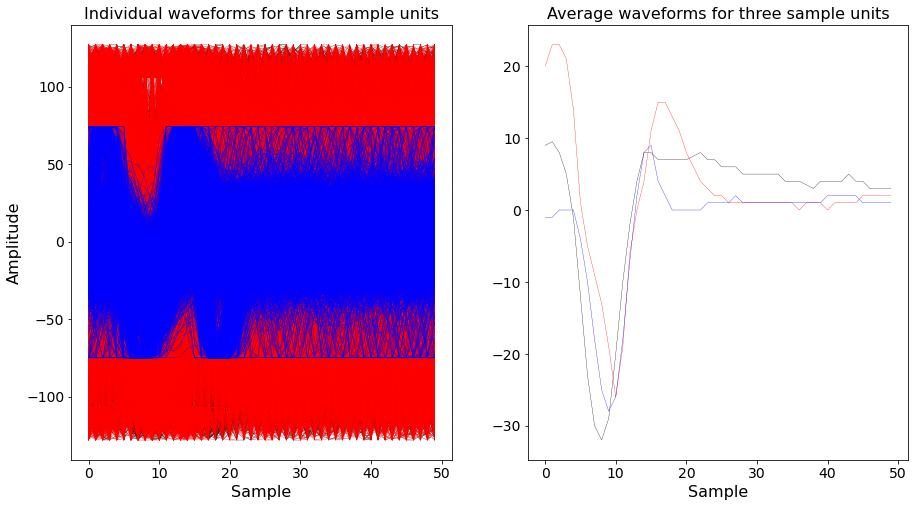

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

ax[0].plot(waveforms[0][:, 0, :].T, color='k', lw=0.3)
ax[0].plot(waveforms[1][:, 0, :].T, color='r', lw=0.3)
ax[0].plot(waveforms[2][:, 0, :].T, color='b', lw=0.3)
ax[0].set_xlabel('Sample', fontsize=16)
ax[0].set_ylabel('Amplitude', fontsize=16)
ax[0].set_title('Individual waveforms for three sample units', fontsize=16)

ax[1].plot(avg_waveforms[0][0].T, color='k', lw=0.3)
ax[1].plot(avg_waveforms[1][0].T, color='r', lw=0.3)
ax[1].plot(avg_waveforms[2][0].T, color='b', lw=0.3)
ax[1].set_xlabel('Sample', fontsize=16)
ax[1].set_title('Average waveforms for three sample units', fontsize=16)

Similarly, we can get templates, maximum channels, and pca scores. 
When these are computed, they are automatically stored in the `SortingExtractor` object, so that they don't need to be recomputed. 

Each waveform is associated with a specific spike, so they are saved as spike *features*:


You may have noticed that 300 waveforms were extracted from the spike train of the first unit. However, it has more spikes:

In [94]:
len(sorting_MS4.get_unit_spike_train(1))

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np

15529

This is because it can be convenient to only compute a subset of waveforms to speed up the calculation. The `waveform_idxs` property contains the spike indexes associated with the waveforms.

In [95]:
sorting_MS4.get_shared_unit_spike_feature_names()

['waveforms']

In [96]:
print(sorting_MS4.get_unit_spike_features(1, 'waveforms_idxs'))

ValueError: waveforms_idxs has not been added to unit 2

Since waveforms are already computed, the next time we (or another function - e.g. `get_unit_templates()`) call it it will just return the stored waveforms.

In [97]:
waveforms = st.postprocessing.get_unit_waveforms(r_cache, sorting_MS4, verbose=True)

Lighthing fast! 

If we want to recompute the waveforms, for example because we want to extract the waveforms divided by group, we can use the `recompute_info` argument (available for all `postprocessing`, `validation`, and `curation` functions).

Where are waveforms stored? We have seen above that each `Extractor` object has an associated tmp folder. Waveforms (and other features, e.g. pca scores) are stored in this folder as binary files:

In [98]:
tmp_folder = sorting_MS4.get_tmp_folder()
print(tmp_folder)
print([(p.name) for p in tmp_folder.iterdir()])

/tmp/tmpriqx1h6o
['waveforms_25.raw', 'waveforms_18.raw', 'waveforms_17.raw', 'waveforms_16.raw', 'waveforms_6.raw', 'waveforms_8.raw', 'waveforms_3.raw', 'waveforms_2.raw', 'waveforms_23.raw', 'waveforms_11.raw', 'waveforms_20.raw', 'waveforms_22.raw', 'waveforms_21.raw', 'waveforms_0.raw', 'waveforms_13.raw', 'waveforms_19.raw', 'waveforms_12.raw', 'waveforms_9.raw', 'waveforms_5.raw', 'waveforms_10.raw', 'waveforms_4.raw', 'waveforms_7.raw', 'waveforms_15.raw', 'waveforms_1.raw', 'waveforms_14.raw', 'waveforms_24.raw']


In [99]:
waveforms_group = st.postprocessing.get_unit_waveforms(
    r_cache,
    sorting_MS4,
    max_spikes_per_unit=None, 
    grouping_property='group',
    recompute_info=True,
    verbose=True
)

Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:02<00:00,  2.86s/it]


In [100]:
sorting_MS4.get_shared_unit_property_names()

['group', 'template', 'waveforms_channel_idxs']

In [101]:
for wf in waveforms_group:
    print(wf.shape)

(9744, 2, 288)
(15529, 2, 288)
(5262, 3, 288)
(1984, 3, 288)
(778, 3, 288)
(5857, 3, 288)
(249, 3, 288)
(5013, 3, 288)
(5993, 3, 288)
(1390, 3, 288)
(4312, 4, 288)
(959, 4, 288)
(959, 4, 288)
(2165, 4, 288)
(5303, 4, 288)
(629, 4, 288)
(741, 4, 288)
(6384, 4, 288)
(986, 4, 288)
(1707, 4, 288)
(3893, 4, 288)
(7164, 4, 288)
(4589, 4, 288)
(7055, 4, 288)
(14349, 4, 288)
(7907, 4, 288)


We can use `spikewidgets` to quickly inspect the spike sorting output:

In [102]:
dir_name

'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'

In [103]:
unit_ids = sorting_MS4.get_unit_ids()

IndexError: index 4 is out of bounds for axis 0 with size 4

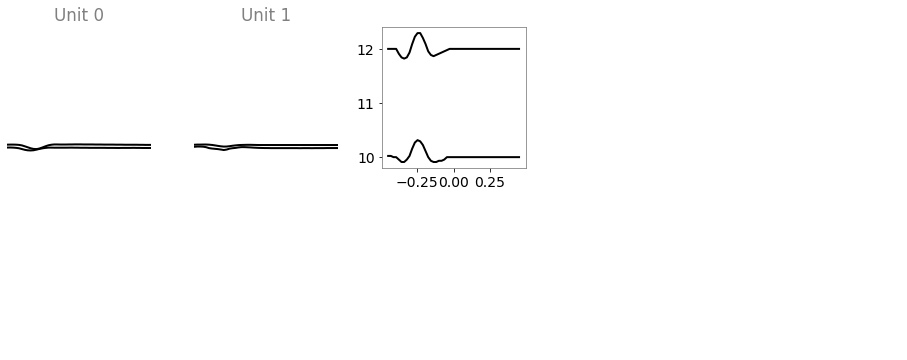

In [104]:
w_wf = sw.plot_unit_templates(sorting=sorting_MS4, recording=r_cache, unit_ids=unit_ids[0:6])

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np

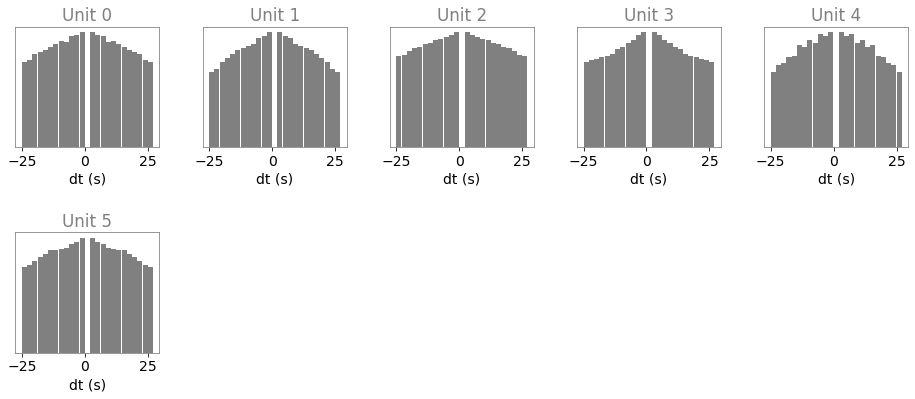

In [105]:
w_acc = sw.plot_autocorrelograms(sorting_MS4, unit_ids=unit_ids[0:6])

### Compute extracellular features
[back to index](#index)

Extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` module of `spiketoolkit` allows one to compute several of these features:

In [106]:
st.postprocessing.get_template_features_list()

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['peak_to_valley',
 'halfwidth',
 'peak_trough_ratio',
 'repolarization_slope',
 'recovery_slope']

In [107]:
features = st.postprocessing.compute_unit_template_features(
    r_cache, 
    sorting_MS4, 
    as_dataframe=True, 
    upsampling_factor=10
)
display(features)

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/spikefeatures/features.py:206: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return_to_base_idx = np.empty(waveforms.shape[0], dtype=np.int)


,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope
0,0.000283,0.000119,-0.159186,6.702624e+05,-13795.099919
1,0.000144,0.000102,-0.149331,7.844700e+05,-7342.186420
2,0.000113,0.000102,-0.344148,4.175395e+05,-1196.643400
3,0.000138,0.000087,-0.749710,7.365211e+05,-37797.208185
4,0.000827,0.000158,-0.154524,5.807759e+04,-216001.365275
5,0.000477,0.000133,-0.103948,2.340823e+05,-2251.436948
6,0.000231,0.000123,-0.793683,6.952632e+05,-92198.648690
7,0.000121,0.000075,-0.577217,9.672842e+05,-31691.012199
8,0.000150,0.000117,-0.051467,4.198572e+05,-1624.176319
9,0.000144,0.000096,-0.541414,8.605981e+05,-35936.349456


For more information about these waveform features, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

### Validation
[back to index](#index)

The `spiketoolkit` package also provides several functions to compute qualitity metrics about the spike sorting results through the `validation` module.

Let's see what metrics are available:

In [108]:
st.validation.get_quality_metrics_list()

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['num_spikes',
 'firing_rate',
 'presence_ratio',
 'isi_violation',
 'amplitude_cutoff',
 'snr',
 'max_drift',
 'cumulative_drift',
 'silhouette_score',
 'isolation_distance',
 'l_ratio',
 'd_prime',
 'noise_overlap',
 'nn_hit_rate',
 'nn_miss_rate']

We can compute a subset of quality metrics using the `compute_quality_metrics` function. 


In [109]:
quality_metrics = st.validation.compute_quality_metrics(
    sorting_MS4, 
    r_cache, 
    metric_names=['firing_rate', 'isi_violation', 'snr'], 
    as_dataframe=True
)
display(quality_metrics)

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

,firing_rate,isi_violation,snr
0,81.200000,0.459876,3.936296
1,129.408333,0.486230,6.146560
2,43.850000,0.400053,2.104809
3,16.533333,0.010233,3.546952
4,6.483333,0.133094,2.631011
5,48.808333,0.443841,2.071735
6,2.075000,0.000000,4.857782
7,41.775000,0.307746,4.953944
8,49.941667,0.525982,3.315629
9,11.583333,0.625429,4.549352


Select units with few isi violations.

In [110]:
unit_ids_of_interest = quality_metrics.loc[quality_metrics['isi_violation'] < 10,:].index.values

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


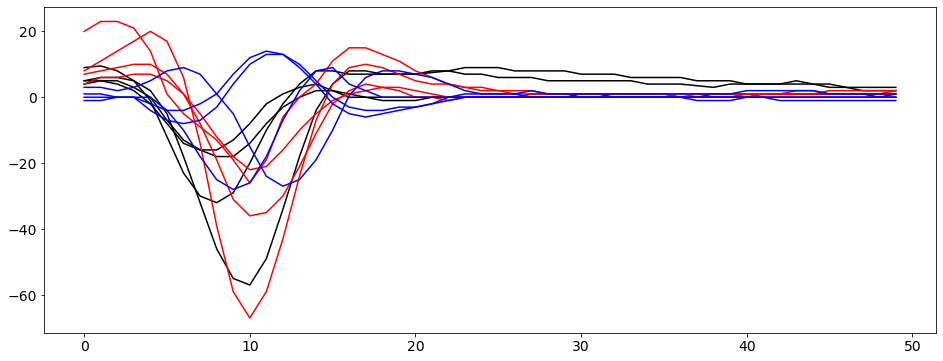

In [111]:
templates = st.postprocessing.get_unit_templates(
    r_cache, sorting_MS4, max_spikes_per_unit=200,
    unit_ids=unit_ids_of_interest,
    save_as_property=True, verbose=True
)

fig, ax = plt.subplots()
ax.plot(templates[0].T, color='k')
ax.plot(templates[1].T, color='r')
ax.plot(templates[2].T, color='b')

<a id="spike_curation"></a>
# 7. Curation
[back to index](#index)

### 1) Manual curation using Phy

To perform manual curation we will export the data to [Phy](https://github.com/cortex-lab/phy). 

In [137]:
st.postprocessing.export_to_phy(
    r_cache, 
    sorting_MS4, 
    output_folder='phy_MS4',
    grouping_property='group', 
    verbose=True, 
    recompute_info=True
)

Converting to Phy format
Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:03<00:00,  3.23s/it]


Fitting PCA of 3 dimensions on 85341 waveforms
Projecting waveforms on PC


/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

Saving files
Saved phy format to:  /home/sbuergers/spikeinterface/hussaini-to-nwb/tidy_venv/phy_MS4
Run:

phy template-gui  /home/sbuergers/spikeinterface/hussaini-to-nwb/tidy_venv/phy_MS4/params.py


If you have trouble using the GUI from phy refer to the instructions here: https://github.com/cortex-lab/phy.

In [138]:
!phy template-gui phy_MS4/params.py

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-sbuergers'


After curating the results we can reload it using the PhySortingExtractor:

In [13]:
sorting_MS4_phy_curated = se.PhySortingExtractor('phy_MS4/', exclude_cluster_groups=['noise'])

In [140]:
print(len(sorting_MS4_phy_curated.get_unit_ids()))
print(f"Unit ids after manual curation: {sorting_MS4_phy_curated.get_unit_ids()}")

26
Unit ids after manual curation: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [141]:
_ = [print(sorting_MS4_phy_curated.get_unit_property(i, 'quality')) for i in sorting_MS4_phy_curated.get_unit_ids()]

unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted
unsorted


### b) Automatic curation based on quality metrics
[back to index](#index)

We will demonstrate here how to select subsets of candidate units based on the quality metrics inter-spike interval (isi) and signal to noise ratio (snr).

In [47]:
st.curation.threshold_isi_violations?

In [42]:
snr_thresh = 4
isi_viol_thresh = 0.0015
duration = r_cache.get_num_frames()

In [43]:
isi_violations = st.validation.compute_isi_violations(
    sorting_MS4, 
    duration_in_frames=r_cache.get_num_frames(), 
    isi_threshold=0.0015
)

In [44]:
isi_violations

array([0.45987646, 0.48622991, 0.39944541, 0.0199797 , 0.35891932,
       0.23387847, 0.44501557, 0.        , 0.30441874, 0.50397046,
       0.51313067, 0.08963957, 0.08286337, 0.00921252, 0.        ,
       0.35123271, 0.        , 0.        , 0.37383273, 0.03216816,
       0.32235082, 0.13541285, 0.5872036 , 0.59966765, 0.42217704,
       0.64490693])

In [102]:
sorting_auto_MS4 = st.curation.threshold_isi_violations(sorting_MS4, isi_viol_thresh, 'greater', duration)
sorting_auto_SC = st.curation.threshold_isi_violations(sorting_SC, isi_viol_thresh, 'greater', duration)

In [103]:
print('Number of units Mountainsort4: {}'.format(len(sorting_auto_MS4.get_unit_ids())))
print('Number of units Spyking Circus: {}'.format(len(sorting_auto_SC.get_unit_ids())))

Number of units Mountainsort4: 4
Number of units Spyking Circus: 1


In [104]:
sorting_auto_MS4 = st.curation.threshold_snrs(sorting_auto_MS4, r_cache, snr_thresh, 'less')
sorting_auto_SC = st.curation.threshold_snrs(sorting_auto_SC, r_cache, snr_thresh, 'less')

In [105]:
print('Number of units Mountainsort4: {}'.format(len(sorting_auto_MS4.get_unit_ids())))
print('Number of units Spyking Circus: {}'.format(len(sorting_auto_SC.get_unit_ids())))

Number of units Mountainsort4: 3
Number of units Spyking Circus: 1


### c) Consensus-based curation
[back to index](#index)

Can we combine the output of multiple sorters to curate the spike sorting output?

Yes, with the `spikecomparison` module we can compare and match the output spike trains of the different sorters, and retrieve a new sorting extractor object containing only the units that were in agreement.

In [106]:
mcmp = sc.compare_multiple_sorters(
    [sorting_auto_SC, sorting_auto_MS4], 
    ['SC', 'MS4'], 
    spiketrain_mode='union',
    verbose=True
)

Multicomaprison step 1: pairwise comparison
  Comparing:  SC  and  MS4
Multicomaprison step 2: make graph
Multicomaprison step 3: clean graph
Removed 0 duplicate nodes
Multicomaprison step 4: extract agreement from graph


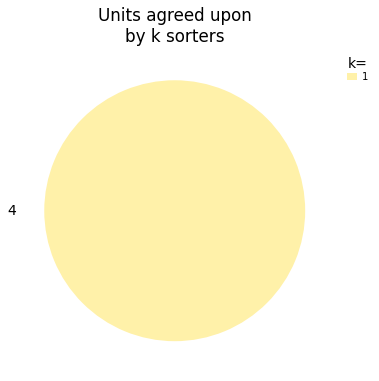

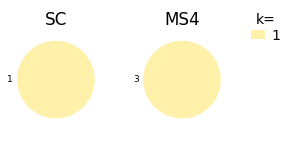

In [107]:
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

In [108]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)

In [109]:
agreement_sorting.get_unit_ids()

[]

In [112]:
cmp_manual_agr = sc.compare_sorter_to_ground_truth(sorting_MS4_phy_curated, agreement_sorting)

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/spikewidgets/widgets/agreementmatrixwidget/agreementmatrixwidget.py:72: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  self.ax.matshow(scores.values, cmap='Greens')
/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/spikewidgets/widgets/agreementmatrixwidget/agreementmatrixwidget.py:99: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  self.ax.set_xlim(-0.5, N2-0.5)


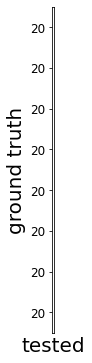

In [113]:
w_agr = sw.plot_agreement_matrix(cmp_manual_agr)

Exception: Unit id is invalid

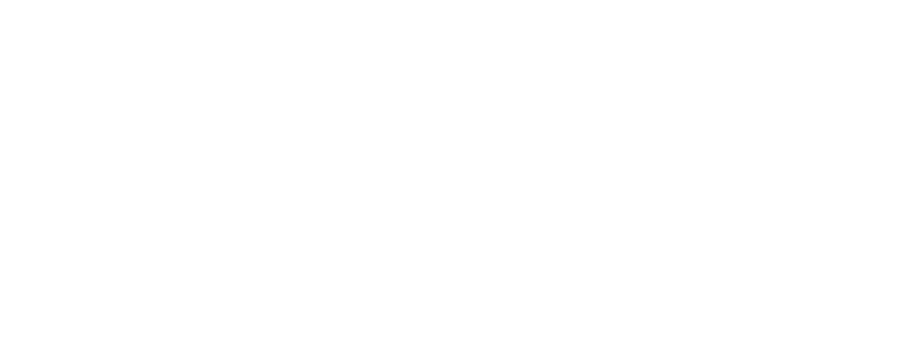

In [114]:
w_wf = sw.plot_unit_templates(sorting=agreement_sorting, recording=r_cache, unit_ids=[1])

In [115]:
st.postprocessing.export_to_phy(
    r_cache, 
    agreement_sorting, 
    output_folder='phy_AGR',
    grouping_property='group', 
    verbose=True, 
    recompute_info=True
)

Exception: No non-empty units in the sorting result, can't save to phy.

<a id="export_nwb"></a>
# 7. Save to / load from NWB
[back to index](#index)

In this section we briefly go through the process of exporting recording extractor and sorting extractor objects to the `nwb` file format. We will use the `spikeextractors` classes `NwbRecordingExtractor` and `NwbSortingExtractor`. It can be useful to pass metadata to the `nwb` file during export (i.e. data that describes the ecephys data in this case) and we illustrate this here by passing information about the recording device.

In [11]:
from pynwb import NWBFile, NWBHDF5IO
from pathlib import Path

In [12]:
metadata = {'Ecephys': {'Device': [{'name': 'Axona',
                                    'description': 'Axona DacqUSB acquisition system'}]}}

In [13]:
nwb_dir = Path(dir_name, 'nwb')

nwb_dir.mkdir(parents=True, exist_ok=True)

In [21]:
se.NwbRecordingExtractor.write_recording(r_cache, nwb_dir / 'axona_re.nwb', metadata=metadata)

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/hdmf/common/table.py:415: UserWarning: An attribute 'name' already exists on DynamicTable 'electrodes' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  warn(msg)
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:802: UserWarning: The recording extractor does not have unscaled traces. Returning scaled traces
  warnings.warn("The recording extractor does not have unscaled traces. Returning scaled traces")


In [24]:
se.NwbSortingExtractor.write_sorting(sorting_MS4_phy_curated, nwb_dir / 'axona_se_MS4_man_curation.nwb')

(Re-)load data into recording and sorting extractor.

In [25]:
recording_nwb = se.NwbRecordingExtractor(nwb_dir / 'axona_re.nwb')

In [26]:
sorting_nwb = se.NwbSortingExtractor(nwb_dir / 'axona_se_MS4_man_curation.nwb', sampling_frequency=48000)

<a id="export_tint"></a>
# 8. Save to / load from TINT
[back to index](#index)

We can export the spike sorted data back to the 'TINT' format in the form of `.X`, `.cut` and `.clu` files. The `.X` files are similar to the tetrode files generated by the Axona acquisition system, except that the spike times are now based on the spike sorting extractor used for the conversion. The `.cut` and `.clu` files contain the unit labels of each spike timestamp.

For the conversion to 'TINT' both a sorting extractor and recording extractor are required. Spike times are read from the sorting extractor and the corresponding waveforms are extracted from the recording extractor. It is always preferable to use a recording extractor based on `.bin` data, because spike times extracted from spike sorters might not exactly correspond to spike times from the thresholding procedure that created the `.X` files from the raw data. When spike times do not correspond exactly, part (or in the worst caes all) of the waveforms will consist of Gaussian noise if based on an `AxonaUnitRecordingExtractor`, because time periods between waveforms are filled with noise when the extractor object is created. 

The `TintConverter` class has the `compare_timestamps_after_conversion()` method to assess the correspondence of timestamps between the `.X` files created from simple thresholding and the `.X` files created using `TintConverter` after spike sorting.

We recommend creating a new folder for the output from `TintConverter` if you do not want to overwrite existing `.X` files. In this case you also need to copy the `.set` file into that new folder. 

In [14]:
from hussaini_lab_to_nwb import TintConverter

We load the recording from `unit` data with no noise to later compare how well the waveforms from the thresholding procedure correspond to the waveforms after spike sorting. To be able to do this comparison we save the `TintConverter` output to a subfolder `tint_conversion`. We also need to copy the set file into this folder to be able to read the data back in afterwards.

In [29]:
if use_raw_data:
    recording = se.AxonaRecordingExtractor(filename=filename)
else:
    recording = se.AxonaUnitRecordingExtractor(filename=filename, noise_std=0)

sorting = se.NwbSortingExtractor(nwb_dir / 'axona_se_MS4_man_curation.nwb', sampling_frequency=48000)

Create new folder for converted data and copy `.set` file into it.

In [30]:
import shutil

output_dir = Path(dir_name, 'tint_conversion')

output_dir.mkdir(parents=True, exist_ok=True)

shutil.copyfile(filename, output_dir / Path(filename).name)

PosixPath('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/tint_conversion/20201004_Raw.set')

Convert spike sorted data to TINT format (`.X`, `.cut`, `.clu`). Note that this step can take a while depending on the size of the recording!

In [151]:
tc = TintConverter()
tc.write_to_tint(recording=recording,
                 sorting=sorting,
                 set_file=output_dir / Path(filename).name)

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/spiketoolkit/postprocessing/postprocessing_tools.py:325: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  channel_unit_group = np.where(channel_groups == unit_group)[0]
<__array_function__ internals>:5: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


ValueError: cannot mmap an empty file

Finally, we can compare the timestamps from the spike sorted data with the timestamps from the thresholded data (original `.X` files).

In [ ]:
if not use_raw_data:

    df = tc.compare_timestamps_after_conversion(
        filename_old=filename,
        filename_new=output_dir / Path(filename).name
    )

    display(df.T)

I hope this notebook was helpful to you. If you have any suggestions, questions or concerns do not hesitate to contact me at `steffen.burgers@catalystneuro.com`.